In [291]:
import torch
import numpy as np
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
import requests
import string
import urllib.request
import urllib.error
from pandas import *
from torchvision import datasets, transforms
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from PIL import Image
import glob
import natsort 
from natsort import natsorted

In [292]:

class CustomDataSet(Dataset):
    def __init__(self, csv_path, directory, transform):
        self.directory = directory
        self.dataframe = pd.read_csv(csv_path, header=0)
        self.labels = np.asarray(self.dataframe['trending'])
        self.images = natsorted(glob.glob(self.directory+'*'))
        self.length = len(self.images)
        self.transform = transform

    def __getitem__(self, index):
        name = self.images[index]
        img = Image.open(name)
        if self.transform is not None:
            img_as_tensor = self.transform(img)
        lb = self.labels[index]
        return img_as_tensor, lb

    def __len__(self):
        return self.length

In [294]:
pre_transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
pre_train_dataset = CustomDataSet("../dataset/output/dataset_mar_23/train.csv", "../CNN/data/trainall/", transform=pre_transform)
pre_train_set, pre_val_set = torch.utils.data.random_split(pre_train_dataset, [int(len(pre_train_dataset)*0.8), len(pre_train_dataset) - int(len(pre_train_dataset)*0.8)])

dataloader = torch.utils.data.DataLoader(pre_train_set, batch_size=32, shuffle=True)

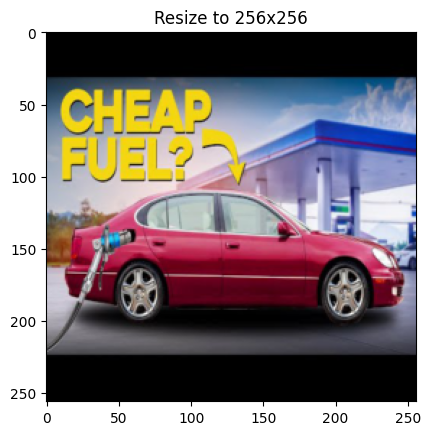

In [363]:
images, _= next(iter(dataloader))
i = 25
images_plot = images.numpy().transpose(0,2,3,1)
plt.title("Resize to 256x256")
plt.imshow(images_plot[i])

In [296]:
from torch.utils.data import DataLoader
loader = torch.utils.data.DataLoader(pre_train_dataset, batch_size=len(pre_train_dataset), shuffle=False, num_workers=0)
def mean_std(loader: DataLoader):
    images, _ = next(iter(loader))
    mean, std = images.mean([0,2,3]), images.std([0,2,3])
    return mean, std
mean_training, std_training = mean_std(loader)
print("mean and std: \n", mean_training, std_training)

mean and std: 
 tensor([0.3370, 0.3092, 0.2969]) tensor([0.3276, 0.3055, 0.3060])


In [327]:
transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor(),transforms.Normalize(mean = mean_training,std=std_training)])
train_dataset = CustomDataSet("../dataset/output/dataset_mar_23/train.csv", "../CNN/data/trainall/", transform=transform)
train_set, val_set = torch.utils.data.random_split(train_dataset, [int(len(train_dataset)*0.9), len(train_dataset) - int(len(train_dataset)*0.9)])
test_dataset = CustomDataSet("../dataset/output/dataset_mar_23/val.csv", "../CNN/data/val/", transform=transform)

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(val_set,  batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset,  batch_size=32, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 0


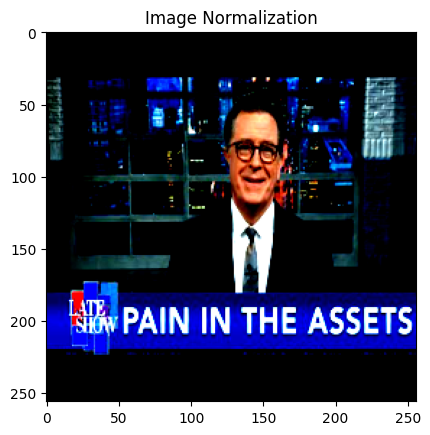

In [364]:
images, labels= next(iter(train_dataloader))
print("label:", labels[i].item())
images_plot = images.numpy().transpose(0,2,3,1)
plt.title("Image Normalization")
plt.imshow(images_plot[i])


In [329]:

class Net(Module):   
    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [334]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 2
num_epochs = 10
batch_size = 64
learning_rate = 0.0001

model = Net(num_classes).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  
criterion = CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
print(model)

Net(
  (layer1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  

In [365]:

total_step = len(train_dataloader)
train_losses = []
val_losses = []
val_accuracy = []
for epoch in range(num_epochs):
    running_loss = 0
    for i, (images, labels) in enumerate(train_dataloader):  
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(loss.detach().numpy())
    print ('Epoch [{}/{}], Step [{}/{}], Running Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, running_loss/total_step))       
    with torch.no_grad():
        correct = 0
        total = 0
        running_loss = 0
        for images, labels in validation_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
        val_losses.append(loss.detach().numpy())
        val_accuracy.append(100 * correct / total)
        print('Accuracy of the network on the {} validation images: {} %, Running Loss: {:.4f}'.format(total, 100 * correct / total, running_loss/len(validation_dataloader))) 

Epoch [1/10], Step [122/122], Running Loss: 0.5118
Accuracy of the network on the 433 validation images: 67.6674364896074 %, Running Loss: 0.5682
Epoch [2/10], Step [122/122], Running Loss: 0.5033
Accuracy of the network on the 433 validation images: 65.35796766743648 %, Running Loss: 0.5890
Epoch [3/10], Step [122/122], Running Loss: 0.4904
Accuracy of the network on the 433 validation images: 68.12933025404158 %, Running Loss: 0.5942
Epoch [4/10], Step [122/122], Running Loss: 0.4737
Accuracy of the network on the 433 validation images: 70.20785219399538 %, Running Loss: 0.5979
Epoch [5/10], Step [122/122], Running Loss: 0.4652
Accuracy of the network on the 433 validation images: 67.4364896073903 %, Running Loss: 0.5834
Epoch [6/10], Step [122/122], Running Loss: 0.4547
Accuracy of the network on the 433 validation images: 67.89838337182448 %, Running Loss: 0.5731
Epoch [7/10], Step [122/122], Running Loss: 0.4392
Accuracy of the network on the 433 validation images: 69.745958429561

In [366]:
pred = []
test_loss = []
with torch.no_grad():
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(test_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        pred.extend(predicted.numpy().tolist())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_loss.append(loss.detach().numpy())
        del images, labels, outputs
    print('Accuracy of the network on the {} test images: {} %'.format(len(test_dataset), 100 * correct / total))   


Accuracy of the network on the 1082 test images: 68.20702402957487 %


In [371]:
with open("CNN_val_prediction.txt", 'w') as out:
    for i in pred:
        out.write(str(i) + '\n')

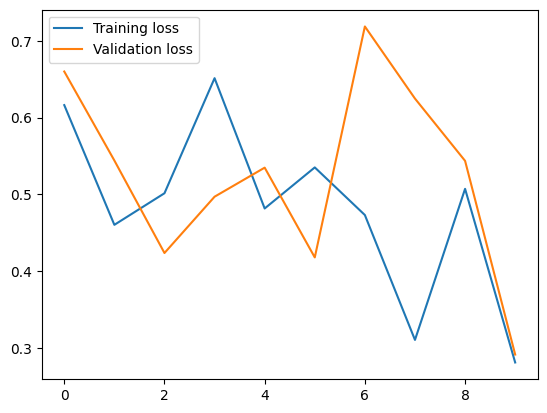

In [368]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

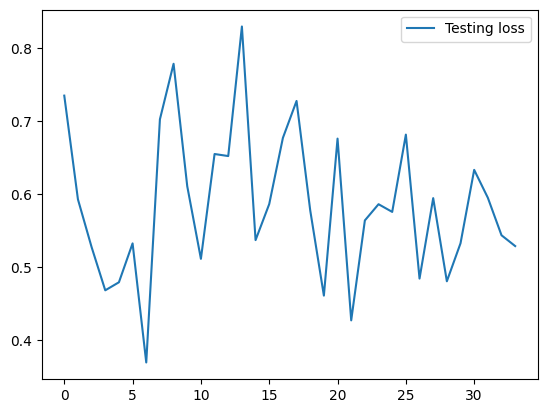

In [369]:
plt.plot(test_loss, label='Testing loss')
plt.legend()
plt.show()

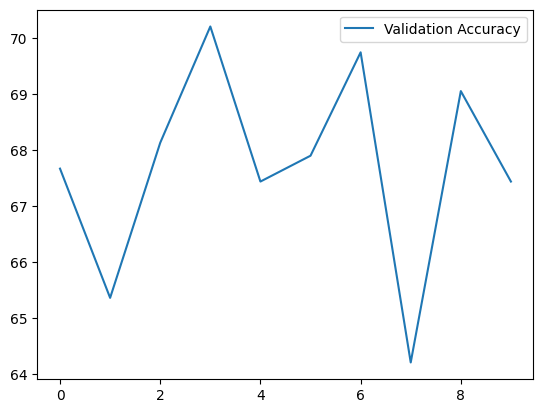

In [370]:
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend()
plt.show()